In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

ModuleNotFoundError: No module named 'nltk.tokenize'

## Read data
We will analyze the titles of a great number of papers in the data science and artificial intelligence community. All the data has been preprocessed as a .csv-file (Excel file)

In [2]:
# Read Excel file or .csv file
papers = pd.read_csv('papers.csv')

# Display first five rows
papers.head(5)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [4]:
# Stopwords are words such as "of", "to", pronouns and abbreviations such as "et c."
# They add no topic information
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(["based", "using", "via"])
escapes = ''.join([chr(char) for char in range(1, 32)])

# The titles are tokenized, split into morphemes, lexemes or in this case words
# This specific tokenizer handles compound words
# Add common compounds
compounds = [("artificial", "intelligence"), 
            ("data", "science"), 
            ("neural", "network"), 
            ("gradient", "descent"), 
            ("mean", "field"), 
            ("cross", "validation"),
            ("neural", "net"),
            ("reinforcement", "learning"),
            ("machine", "learning"),
            ("bayesian", "inference")]

tokenizer = nltk.tokenize.MWETokenizer(compounds, separator=' ')

# We will also add lemmatization, only using the root in common words
lemmatizer = nltk.stem.WordNetLemmatizer()

# We map (apply to each row in the database) filters removing punctuations and stopwords
    papers["title_filter"] = papers["title"].map(lambda x: re.sub('[:,\.!?]', '', x))\
                                        .map(lambda x: [w.lower() for w in x.split(" ")])\
                                        .map(lambda x: [lemmatizer.lemmatize(w) for w in x] )\
                                        .map(lambda x: tokenizer.tokenize(x))\
                                        .map(lambda x: [w for w in x if w not in escapes])\
                                        .map(lambda x: [w for w in x if w not in stopwords])

In [5]:
from itertools import chain

# Create a big list of all the words in the titles
title_list =  [w for w in chain(*papers["title_filter"])]

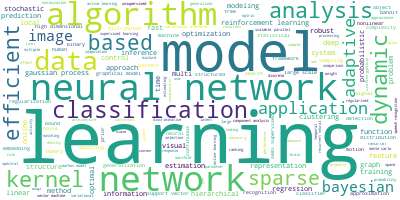

In [6]:
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(title_list)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

## Topic modelling
We will now try to identify if there are any common cluster of terms that go together. So called topics. This is an automated way to get an overview of a document or number of documents.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(papers["title_filter"].map(lambda x: " ".join(x)))

In [8]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

n_topics = 5
lda = LDA(n_components=n_topics).fit(X)


In [9]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [10]:
display_topics(lda, vectorizer.get_feature_names(), 10)

Topic 0:
network neural model bayesian learning probabilistic recurrent dynamic recognition inference
Topic 1:
learning model information time gradient decision sampling markov process structured
Topic 2:
learning algorithm optimization model function reinforcement based stochastic efficient online
Topic 3:
model process kernel gaussian analysis learning regression inference data high
Topic 4:
learning multi neuron network model feature visual image field coding


In [12]:
%pip install pyldavis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, X, vectorizer)

  Using cached pyLDAvis-2.1.2.tar.gz (1.6 MB)
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=e42e9361fc141f87eafa475234adf08e9acf027ed4e987c30e138b4ac8e46761
  Stored in directory: /home/vws/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyldavis
Note: you may need to restart the kernel to use updated packages.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.111027  0.066743       1        1  24.874499
0     -0.160124  0.008805       2        1  22.273179
3      0.064586 -0.200385       3        1  19.934311
1      0.112411  0.095328       4        1  17.041522
4     -0.127900  0.029510       5        1  15.876489, topic_info=            Term        Freq       Total Category  logprob  loglift
2954     network  778.000000  778.000000  Default  30.0000  30.0000
2958      neural  582.000000  582.000000  Default  29.0000  29.0000
127    algorithm  297.000000  297.000000  Default  28.0000  28.0000
2860       multi  212.000000  212.000000  Default  27.0000  27.0000
3507     process  241.000000  241.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
4265    spectral   29.965890   73.475409   Topic5  -5.4732   0.9434
3065      object   32.740943  106.501404   Topic5  -5.3846   0.6608
735   clustering   33.885641  163.629064   Topic5  -5.3503   0.2657
4508      system   31.994507  132.075780   Topic5  -5.4077   0.4225
4043   selection   30.341427   95.089164   Topic5  -5.4608   0.6980

[348 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
52        1  0.641647      active
52        2  0.138394      active
52        4  0.213882      active
54        1  0.934596       actor
61        4  0.182595  adaptation
...     ...       ...         ...
4939      2  0.128319    weighted
4939      4  0.812684    weighted
4939      5  0.042773    weighted
4963      5  0.924977      winner
4987      1  0.917522       worst

[599 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5])

In [6]:
from collections import Counter
count   = Counter(title_list)
common  = dict(count.most_common(10))

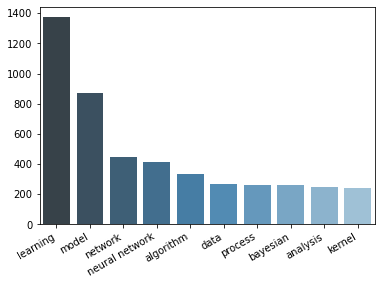

In [7]:
ax = sns.barplot(x = [*common.keys()], y = [*common.values()], palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")
plt.show()

(array([ 285.,  414.,  450.,  453.,  499.,  612.,  628.,  804., 1034.,
        2062.]),
 array([1987., 1990., 1993., 1996., 1999., 2002., 2005., 2008., 2011.,
        2014., 2017.]),
 <a list of 10 Patch objects>)

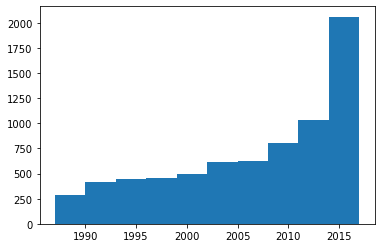